# PySWMM - MLFlow Integration

This notebook demonstrates the basic capability provided by the PySWMM API to EPA SWMM. The basic example uses a simple tutorial model developed in PCSWMM, contained for present purposes in the `pcswmm_ex01/example01.inp` file. The PySWMM API can be used in conjuction with professional grade model development applications like PCSWMM to enable programmatic control of stormwater collection system models.

## Outline
The basic functionalities demonstrated in this notebook include programmatic manipulation of the previously created SWMM model to:

-  Read model output (from PCSWMM runs) in Jupyter
-  Write changes to model input files from Jupyter
-  Run the SWMM model programatically from Jupyter
-  Generate simple interactive graphics summarizing impacts of changes

To access a SWMM outfile, you need to initialize a `pyswmm.output.Output` object. Once the `Output` object is initialized, you can use pre-defined methods to access data in the binary file.

In [1]:
from pyswmm import Output, Simulation
import swmmio
from swmm.toolkit.shared_enum import NodeAttribute

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import mlflow

C:\Users\gcoyle\AppData\Roaming\Python\Python39\site-packages\mlflow\tracking\_tracking_service\utils.py:161: UserWarning: Failure attempting to register store for scheme "adbazureml": No module named 'requests_oauthlib'
  _tracking_store_registry.register_entrypoints()
C:\Users\gcoyle\AppData\Roaming\Python\Python39\site-packages\mlflow\tracking\_tracking_service\utils.py:161: UserWarning: Failure attempting to register store for scheme "azureml": No module named 'requests_oauthlib'
  _tracking_store_registry.register_entrypoints()
C:\Users\gcoyle\AppData\Roaming\Python\Python39\site-packages\mlflow\store\artifact\artifact_repository_registry.py:94: UserWarning: Failure attempting to register artifact repository for scheme "adbazureml": No module named 'requests_oauthlib'
  _artifact_repository_registry.register_entrypoints()
C:\Users\gcoyle\AppData\Roaming\Python\Python39\site-packages\mlflow\store\artifact\artifact_repository_registry.py:94: UserWarning: Failure attempting to regist

# MLFlow prelims

Where is the tracking uri?

In [2]:
mlflow.get_tracking_uri()

'file:///C:/DTProjects/SWMM/mlruns'

In [3]:
# set experiment name
mlflow.set_experiment(experiment_name="simple-swmm-mlflow-demo")

<Experiment: artifact_location='file:///C:/DTProjects/SWMM/mlruns/1', experiment_id='1', lifecycle_stage='active', name='simple-swmm-mlflow-demo', tags={}>

Set up basic experiment - changing rainfall input series and conduit roughness:

In [4]:
def generate_rain(inpath='pcswmm_ex01/example1.inp'):
    """
    Extract rainfall from input file and randomly augment it with Gaussian noise, returning new rainfall.
    """
    rainfall = swmmio.utils.dataframes.dataframe_from_inp(inpath, section='TIMESERIES')
    new_rain = np.array([random.gauss(i, sigma=0.1) for i in rainfall['Value'].values])
    return new_rain

def modify_roughness(roughness):
    """
    Multiply given roughness parameter by uniform random number between 0 and 2.
    """
    roughness = roughness*np.random.uniform(0,2)
    return roughness

def run_experiment(index, inpath='pcswmm_ex01/example1.inp'):
    """
    Build a new experiment file, run it and log run info to MLFlow tracking database.
    """
    # update experiment rainfall
    new_rain = generate_rain(inpath)
    baseline = swmmio.Model(inpath)
    baseline.inp.timeseries.Value = new_rain

    # update experiment roughness coefficient
    roughness = baseline.inp.conduits.loc['C1','Roughness']
    roughness = roughness*np.random.uniform(0,2)
    baseline.inp.conduits.loc['C1','Roughness'] = roughness

    # save new experiment run input file
    inpath = 'pcswmm_ex01/mlflow_example_{}.inp'.format(index)
    baseline.inp.save(inpath)

    # run simulation
    with Simulation(inpath) as sim:
        sim.execute()

    # read and log simulation to experiment 
    outpath = 'pcswmm_ex01/mlflow_example_{}.out'.format(index)
    with Output(outpath) as out:
        ts1 = pd.Series(out.node_series(
            'OF1',
            NodeAttribute.INVERT_DEPTH
        ))
    plt.figure(figsize=(12,6));
    plt.plot(ts0.index, ts0.values, label='original');
    plt.plot(ts1.index, ts1.values, label='new');
    plt.legend();
    plt.savefig('figures/comparison.png', dpi=400);

    with mlflow.start_run():
        # first, we can log run artifacts (like input/output files)
        mlflow.log_artifact(local_path=inpath, artifact_path="input_files")
        mlflow.log_artifact(local_path=outpath, artifact_path="output_files")
        # mlflow.log_figure(fig, artifact_file='comparison.png')
        mlflow.log_artifact(local_path='figures/comparison.png', artifact_path='figures')
        
        # and now log run parameters and metrics
        mlflow.log_param("c1_roughness", roughness)
        mlflow.log_metric("of1_maxdepth", ts1.values.max())

# get initial depth series at OF1 for reference
outpath = 'pcswmm_ex01/example1.out'
with Output(outpath) as out:
    ts0 = pd.Series(out.node_series(
        'OF1',
        NodeAttribute.INVERT_DEPTH
    ))


... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete
... SWMM Version 5.2.4
... Run Complete

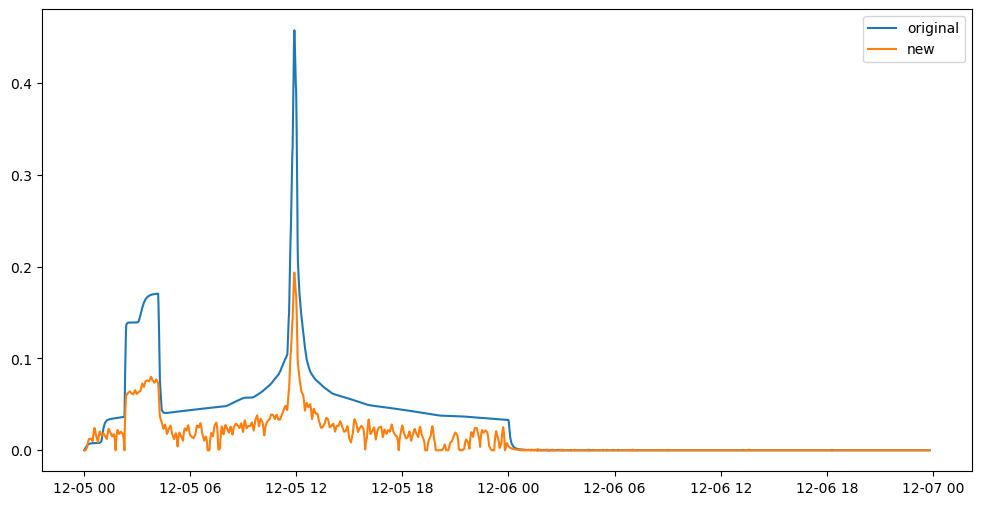

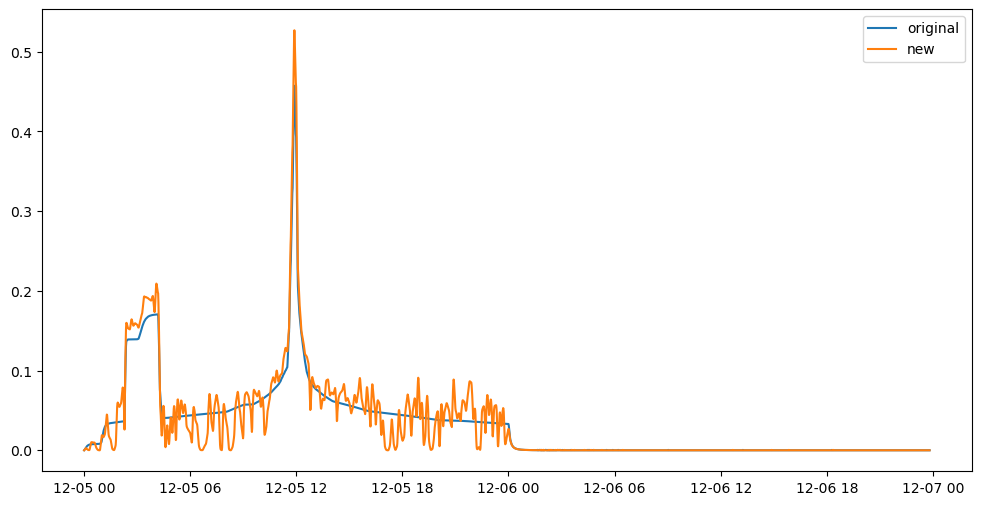

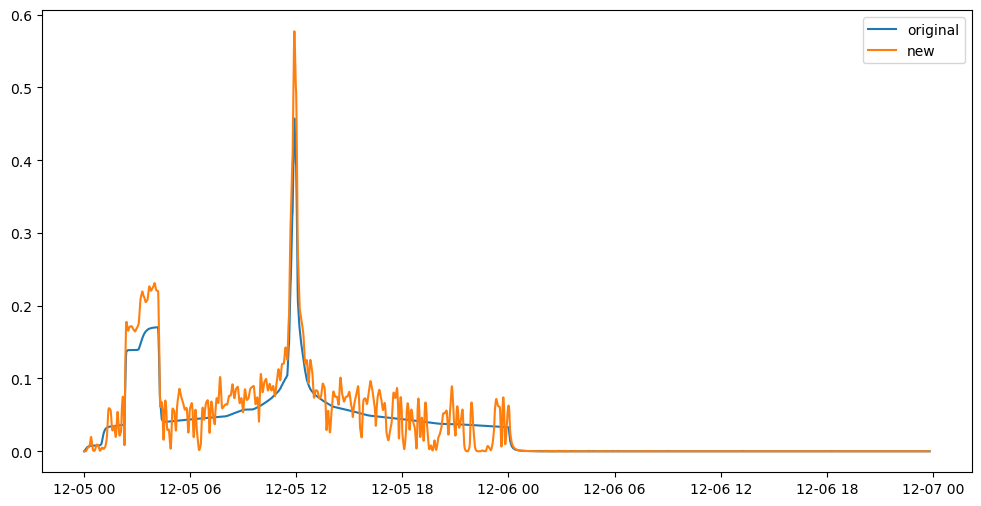

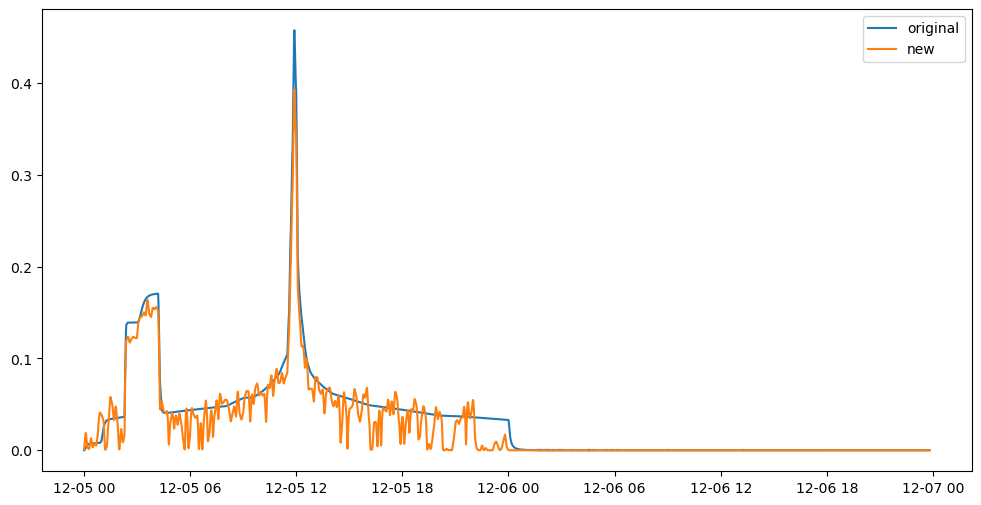

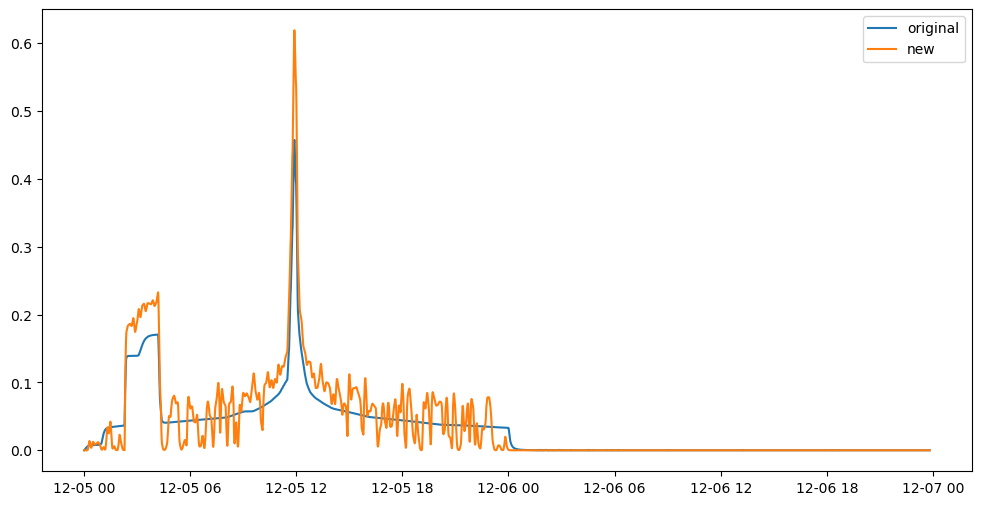

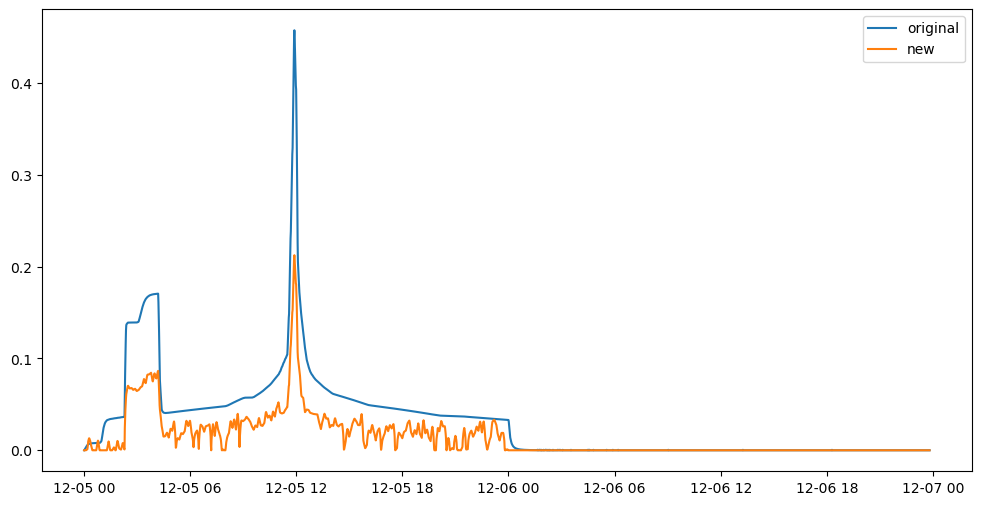

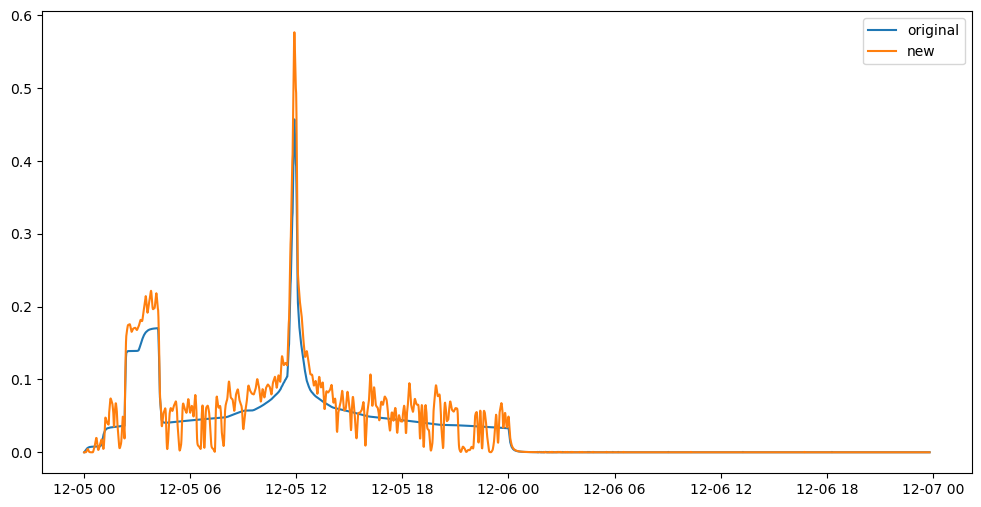

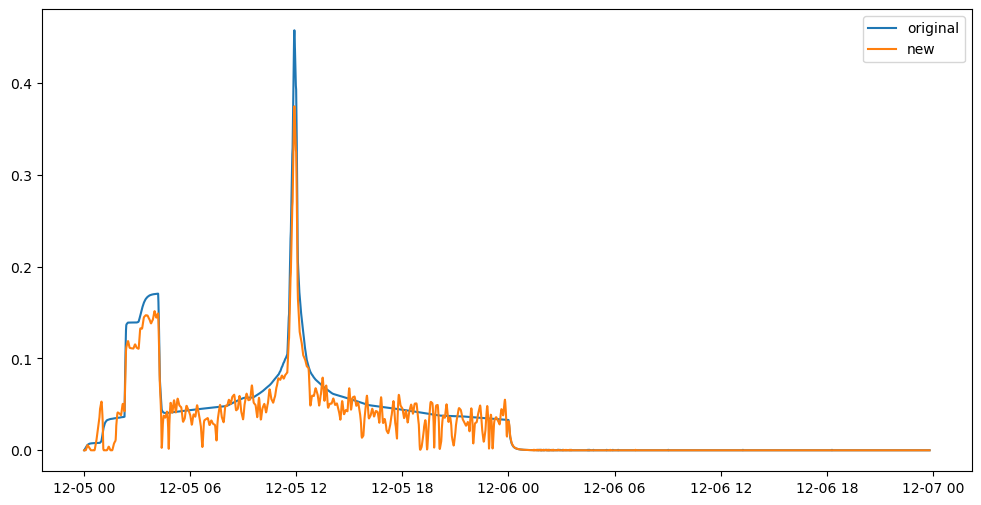

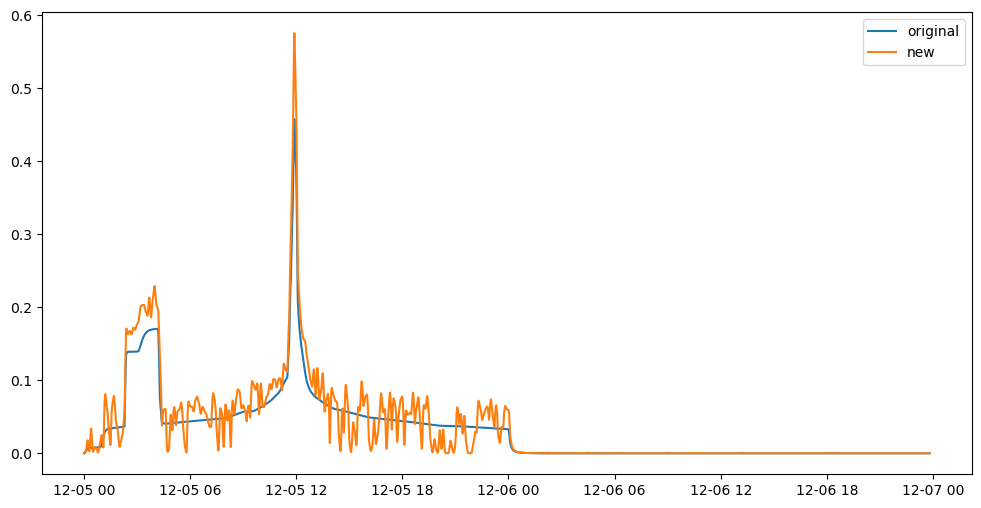

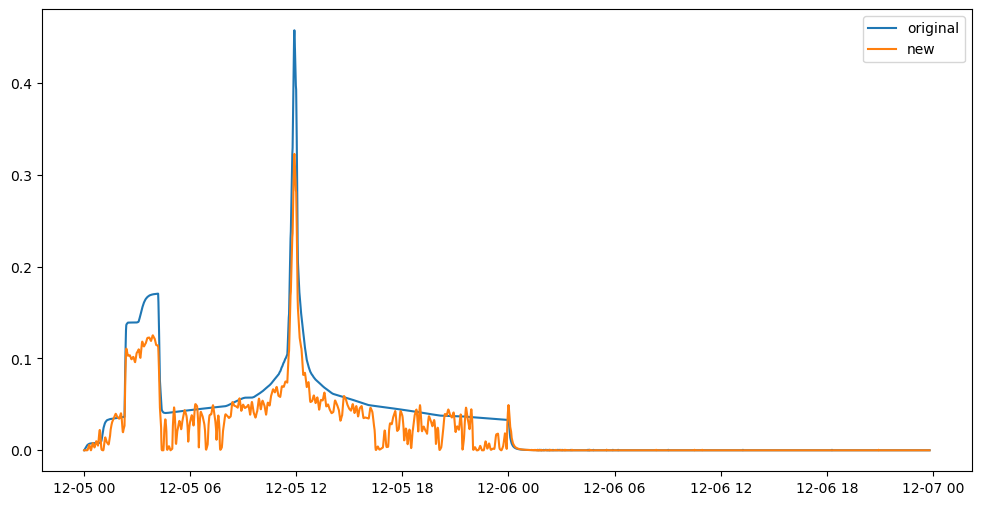

In [5]:
for i in range(10):
    run_experiment(i)

In [6]:
exp_runs = mlflow.search_runs(experiment_names=['simple-swmm-mlflow-demo'])
exp_runs

,run_id,experiment_id,...,tags.mlflow.user,tags.mlflow.source.type
0,83a55a31e0b848c1a5240c8bf987dcbc,1,...,GCoyle,LOCAL
1,53b20eb7a65d4b998b31c248e8815a01,1,...,GCoyle,LOCAL
2,6fa071c0a39a4c578355337e5822b5f3,1,...,GCoyle,LOCAL
3,d4c9c00319144cb082b3777873fca40e,1,...,GCoyle,LOCAL
4,fa3b2932ba594e3abeb50e792ad5c372,1,...,GCoyle,LOCAL
5,ade6570ea3084f878c80a3828cc60bc6,1,...,GCoyle,LOCAL
6,954918487dd244f19162623f2d77de49,1,...,GCoyle,LOCAL
7,77dd83680afa4e0f86af103ee48aad52,1,...,GCoyle,LOCAL
8,ea8060cf5cba4cb3868beb95b43d996d,1,...,GCoyle,LOCAL
9,38169e6335ca46fcaa00cc79756f4aa9,1,...,GCoyle,LOCAL


In [7]:
exp_runs.keys()

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.of1_maxdepth', 'params.c1_roughness',
       'tags.mlflow.source.name', 'tags.mlflow.user',
       'tags.mlflow.source.type'],
      dtype='object')

## Summarize KPIs over all runs 

In [8]:
roughness = exp_runs['params.c1_roughness']
max_depth = exp_runs['metrics.of1_maxdepth']

In [9]:
roughness = np.array([round(float(i),4) for i in roughness.values])
max_depth = np.array([round(float(i),4) for i in max_depth.values])

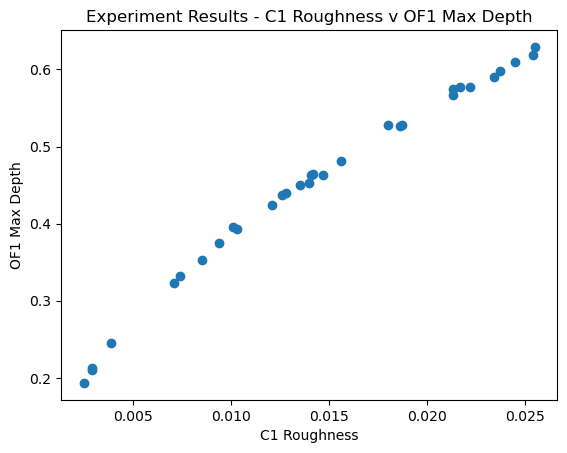

In [10]:
plt.title("Experiment Results - C1 Roughness v OF1 Max Depth")
plt.scatter(roughness, max_depth)
plt.ylabel("OF1 Max Depth")
plt.xlabel("C1 Roughness");

## Or dig into an individual run

For example, can we recover the details for the run with the lowest OF1 depth?

In [11]:
desired_run = exp_runs.iloc[exp_runs['metrics.of1_maxdepth'].idxmin()]
desired_run

run_id                                                                         38169e6335ca46fcaa00cc79756f4aa9
experiment_id                                                                                                 1
status                                                                                                 FINISHED
artifact_uri                     file:///C:/DTProjects/SWMM/mlruns/1/38169e6335ca46fcaa00cc79756f4aa9/artifacts
start_time                                                                     2023-09-20 20:48:09.689000+00:00
end_time                                                                       2023-09-20 20:48:09.756000+00:00
metrics.of1_maxdepth                                                                                   0.193449
params.c1_roughness                                                                        0.002460733202211223
tags.mlflow.source.name    c:\Users\gcoyle\Anaconda3\envs\pyswmm-mlflow\lib\site-packages\ipykernel_laun

And examine the logged depth graph?

In [12]:
from IPython.display import Image
import os

In [17]:
img_path = os.path.join(desired_run.artifact_uri.strip('file:///'),'figures/comparison.png')

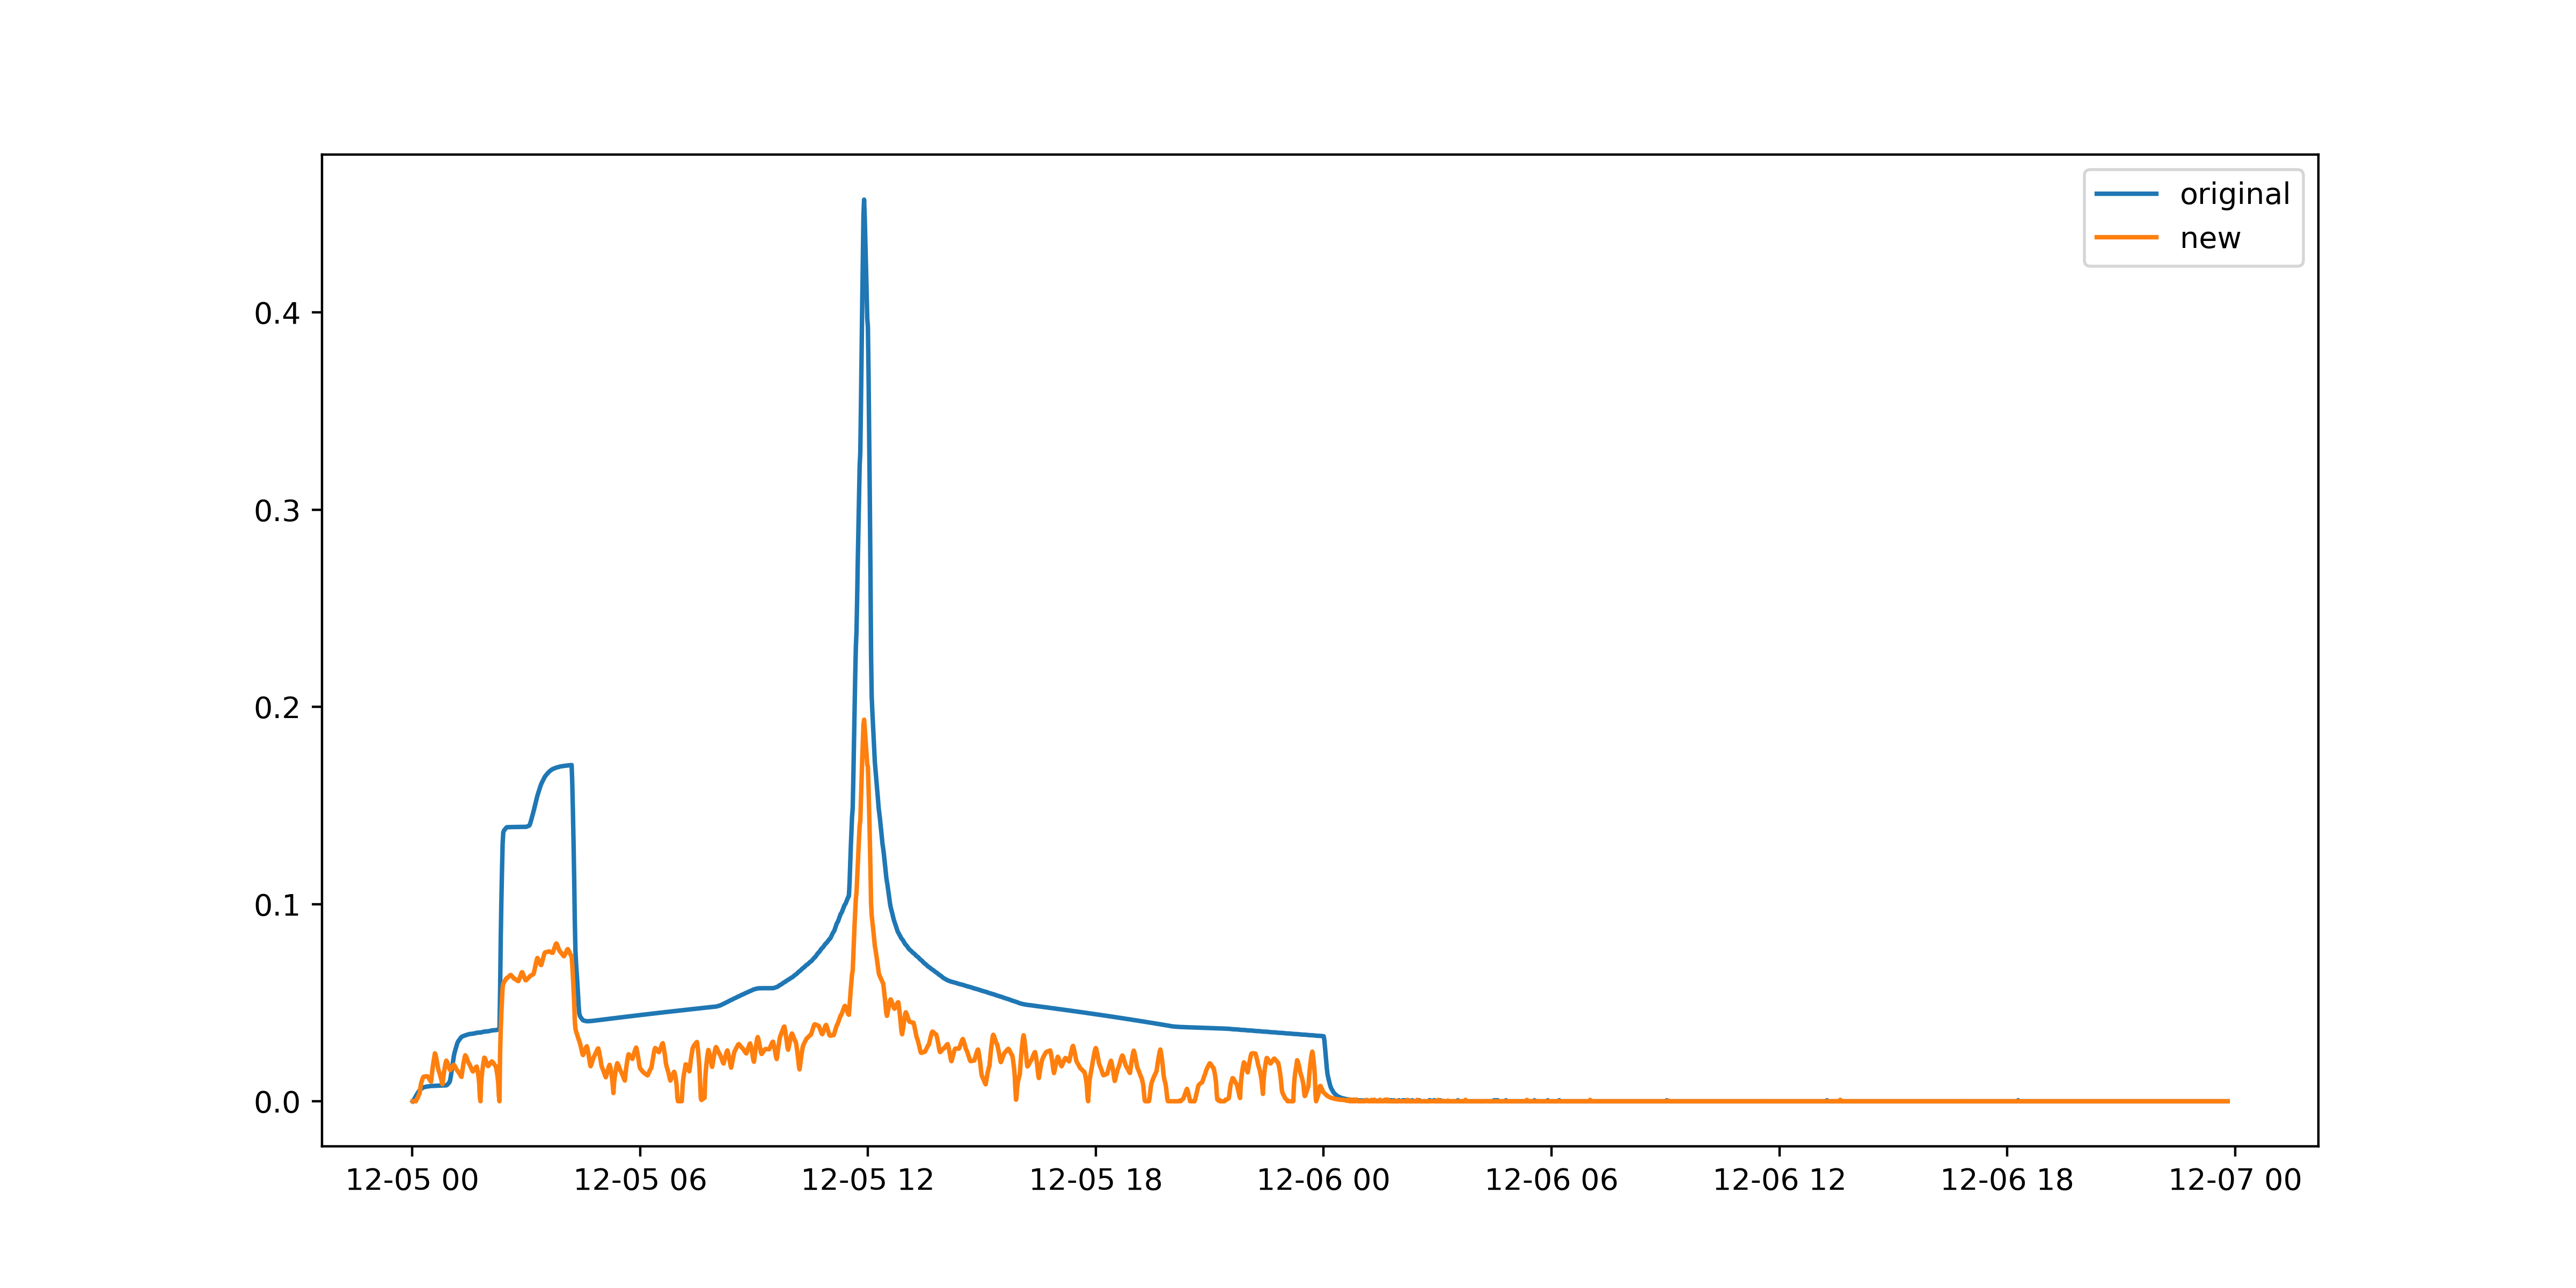

In [18]:
Image(filename=img_path)

There's much more MLFlow can do - such as: 
-  logging and tracking model versions
-  tracking model lifecycle from development through deployment (i.e., operational forecasting) and deprecation
-  logging observable metrics and runtime artifacts during deployment

All of these features are widely used in MLOps workflows, and more features are added continually. It is possible to extend MLFlow to more tightly integrate with APIs like PySWMM, further reducing the lines of code required to implement project-based tracking.